# Fine-tune OpenStack Model on Apache Attack Detection Dataset

This notebook fine-tunes the **OpenStack pre-trained transformer** on the **150k Apache training logs** dataset for attack detection.

**Dataset:** `apache_training_150k.log` with labels from `apache_training_150k_labels.json`
- **Total logs:** 150,000
- **Normal logs:** 127,584 (85%)
- **Attack logs:** 22,416 (15%)
- **Attack types:** SQL injection, XSS, path traversal, command injection, brute force, scanner, DDoS, data exfiltration, API abuse

**Strategy:**
1. Load OpenStack pre-trained `best.pt` checkpoint
2. Parse Apache logs with HTTP-aware normalization
3. Extract templates using Drain3
4. Create session-based sequences (by IP)
5. Fine-tune model on all logs (normal + attacks) to learn:
   - Normal HTTP request patterns
   - Attack signature patterns
   - Sequence-based anomaly detection
6. Save fine-tuned model for downstream attack detection

**Key Features:**
- Transfer learning from OpenStack domain to Apache domain
- HTTP-aware normalization (methods, paths, status codes)
- Large-scale training (150k logs)
- Attack-aware template mining

In [1]:
import json
import math
import re
from pathlib import Path
from collections import defaultdict, Counter
from datetime import datetime

import yaml
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid' if 'seaborn-v0_8-darkgrid' in plt.style.available else 'default')
%matplotlib inline

/home/tpi/anaconda3/envs/log_anomaly/lib/python3.11/site-packages/torch/cuda/__init__.py:54: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
# Setup paths
CWD = Path.cwd().resolve()
REPO_ROOT = CWD.parent if CWD.name == 'notebooks' else CWD

# Load OpenStack config as base
cfg = yaml.safe_load((REPO_ROOT / 'configs/train_openstack.yaml').read_text())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"{'='*70}")
print(f"APACHE ATTACK DETECTION FINE-TUNING")
print(f"{'='*70}")
print(f"Device: {device}")
print(f"Repo root: {REPO_ROOT}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Current GPU Memory:")
    print(f"  Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"  Reserved:  {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

APACHE ATTACK DETECTION FINE-TUNING
Device: cuda
Repo root: /home/tpi/distil_shahreyar
GPU: Quadro RTX 6000
Memory: 25.19 GB
Current GPU Memory:
  Allocated: 0.00 MB
  Reserved:  0.00 MB


## 1. Load Apache Training Dataset (150k logs)

In [3]:
# Load dataset
log_file = REPO_ROOT / 'data/apache_logs/apache_training_150k.log'
label_file = REPO_ROOT / 'data/apache_logs/apache_training_150k_labels.json'

print(f"\n{'='*70}")
print(f"LOADING APACHE TRAINING DATASET")
print(f"{'='*70}")
print(f"Log file:   {log_file}")
print(f"Label file: {label_file}")

# Load labels
with open(label_file, 'r') as f:
    label_data = json.load(f)

print(f"\n📊 Dataset Statistics:")
print(f"  Total logs:      {label_data['total_logs']:,}")
print(f"  Normal logs:     {label_data['normal_logs']:,} ({label_data['normal_logs']/label_data['total_logs']*100:.1f}%)")
print(f"  Attack logs:     {label_data['attack_logs']:,} ({label_data['attack_ratio']*100:.1f}%)")

print(f"\n⚠️  Attack Type Distribution:")
for attack_type, count in sorted(label_data['attack_types'].items(), key=lambda x: x[1], reverse=True):
    print(f"  {attack_type:<20} {count:>6,} logs ({count/label_data['attack_logs']*100:>5.1f}% of attacks)")

print(f"\n✓ Dataset loaded successfully")


LOADING APACHE TRAINING DATASET
Log file:   /home/tpi/distil_shahreyar/data/apache_logs/apache_training_150k.log
Label file: /home/tpi/distil_shahreyar/data/apache_logs/apache_training_150k_labels.json

📊 Dataset Statistics:
  Total logs:      150,000
  Normal logs:     127,584 (85.1%)
  Attack logs:     22,416 (15.0%)

⚠️  Attack Type Distribution:
  brute_force           4,408 logs ( 19.7% of attacks)
  scanner               3,491 logs ( 15.6% of attacks)
  sqli                  3,395 logs ( 15.1% of attacks)
  xss                   2,671 logs ( 11.9% of attacks)
  ddos                  2,267 logs ( 10.1% of attacks)
  path_traversal        2,252 logs ( 10.0% of attacks)
  cmd_injection         1,737 logs (  7.7% of attacks)
  api_abuse             1,109 logs (  4.9% of attacks)
  data_exfil            1,086 logs (  4.8% of attacks)

✓ Dataset loaded successfully


## 2. Apache Log Parser with HTTP-Aware Normalization

In [4]:
# Apache Combined Log Format parser
APACHE_PATTERN = re.compile(
    r'^(?P<ip>\S+) \S+ \S+ '
    r'\[(?P<timestamp>[^\]]+)\] '
    r'"(?P<method>\S+) (?P<path>\S+) (?P<protocol>\S+)" '
    r'(?P<status>\d+) '
    r'(?P<size>\S+)'
    r'(?: "(?P<referrer>[^"]*)")?'
    r'(?: "(?P<user_agent>[^"]*)")?'
)

# Normalization patterns
RE_IPv4 = re.compile(r'\b(?:(?:25[0-5]|2[0-4]\d|1?\d?\d)\.){3}(?:25[0-5]|2[0-4]\d|1?\d?\d)\b')
RE_NUM = re.compile(r'(?<![A-Za-z])[-+]?\d+(?:\.\d+)?(?![A-Za-z])')
RE_PATH = re.compile(r'(?:/[^/\s]+)+')
RE_URL = re.compile(r'https?://\S+')
RE_HEX = re.compile(r'\b[0-9a-fA-F]{8,}\b')

def normalize_apache_message(msg: str) -> str:
    """
    HTTP-aware normalization for Apache logs.
    Preserves attack signatures while normalizing benign variations.
    """
    if not msg:
        return msg
    
    out = msg
    
    # Replace full URLs (but keep paths for attack detection)
    out = RE_URL.sub('<URL>', out)
    
    # Replace IP addresses (but keep structure)
    out = RE_IPv4.sub('<IP>', out)
    
    # Normalize paths while preserving attack patterns
    def normalize_path(match):
        path = match.group(0)
        
        # Preserve SQL injection patterns
        if any(kw in path.lower() for kw in ['select', 'union', 'insert', 'drop', 'delete', '--', 'or 1=1']):
            return path  # Keep exact pattern for SQL injection
        
        # Preserve XSS patterns
        if any(kw in path.lower() for kw in ['<script', 'javascript:', 'onerror', 'onload']):
            return path  # Keep exact pattern for XSS
        
        # Preserve path traversal patterns
        if '../' in path or '..\\' in path:
            return path  # Keep exact pattern for path traversal
        
        # Preserve command injection patterns
        if any(kw in path for kw in ['|', ';', '&&', '$(', '`']):
            return path  # Keep exact pattern for command injection
        
        # For normal paths, normalize numbers and hex
        path = re.sub(r'/\d+', '/<NUM>', path)
        path = re.sub(r'/[0-9a-fA-F]{8,}', '/<HEX>', path)
        
        return path
    
    out = RE_PATH.sub(normalize_path, out)
    
    # Bucket non-path numbers (status codes, sizes, etc.)
    def bucket_number(m):
        s = m.group(0)
        
        # Don't normalize numbers that might be part of attack signatures
        if any(c in s for c in ['=', '<', '>']):
            return s
        
        try:
            val = float(s) if '.' in s else int(s)
            if val == 0:
                return '<NUM_E0>'
            mag = int(math.floor(math.log10(abs(val))))
            return f'<NUM_E{mag}>'
        except:
            return '<NUM>'
    
    # Only bucket numbers that are NOT in URLs/paths (already processed)
    # Look for standalone numbers
    parts = out.split()
    normalized_parts = []
    for part in parts:
        # If it looks like a pure number (not in a path/URL), bucket it
        if RE_NUM.fullmatch(part):
            normalized_parts.append(bucket_number(RE_NUM.match(part)))
        else:
            normalized_parts.append(part)
    
    out = ' '.join(normalized_parts)
    
    # Normalize whitespace
    out = re.sub(r'\s+', ' ', out).strip()
    
    return out

def parse_apache_log(log_path: Path):
    """Parse Apache access log file with attack-aware normalization"""
    records = []
    
    print(f"\nParsing Apache logs from: {log_path}")
    
    with open(log_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line_num, line in enumerate(tqdm(f, desc="Parsing logs"), 1):
            line = line.strip()
            if not line:
                continue
            
            match = APACHE_PATTERN.match(line)
            if not match:
                # Unparseable line - keep for anomaly detection
                records.append({
                    'timestamp': pd.NaT,
                    'ip': None,
                    'method': None,
                    'path': None,
                    'status': None,
                    'size': None,
                    'raw_message': line,
                    'norm_message': normalize_apache_message(line),
                    'line_num': line_num
                })
                continue
            
            d = match.groupdict()
            
            # Parse timestamp
            try:
                ts = pd.to_datetime(d['timestamp'], format='%d/%b/%Y:%H:%M:%S %z', errors='coerce')
            except:
                ts = pd.NaT
            
            # Create message for template mining (include method, path, protocol, status)
            # This preserves HTTP semantics for better attack detection
            message = f"{d.get('method', 'GET')} {d.get('path', '/')} {d.get('protocol', 'HTTP/1.1')} {d.get('status', '200')}"
            
            records.append({
                'timestamp': ts,
                'ip': d['ip'],
                'method': d.get('method'),
                'path': d.get('path'),
                'status': d.get('status'),
                'size': d.get('size'),
                'raw_message': message,
                'norm_message': normalize_apache_message(message),
                'line_num': line_num
            })
    
    df = pd.DataFrame(records)
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    return df

# Parse logs
df = parse_apache_log(log_file)

print(f"\n{'='*70}")
print(f"APACHE LOG PARSING COMPLETE")
print(f"{'='*70}")
print(f"Total log lines:     {len(df):,}")
print(f"Valid timestamps:    {df['timestamp'].notna().sum():,}")
print(f"Unique IPs:          {df['ip'].nunique():,}")
print(f"Unique paths:        {df['path'].nunique():,}")
print(f"HTTP methods:        {df['method'].value_counts().to_dict()}")
print(f"Status code dist:    {df['status'].value_counts().head(10).to_dict()}")

print(f"\n📝 Sample normalized messages (first 10):")
for i, msg in enumerate(df['norm_message'].head(10), 1):
    print(f"  {i}. {msg}")


Parsing Apache logs from: /home/tpi/distil_shahreyar/data/apache_logs/apache_training_150k.log


Parsing logs: 0it [00:00, ?it/s]


APACHE LOG PARSING COMPLETE
Total log lines:     150,000
Valid timestamps:    143,905
Unique IPs:          70
Unique paths:        17,652
HTTP methods:        {'GET': 128429, 'POST': 8143, 'DELETE': 3703, 'PUT': 3630}
Status code dist:    {'200': 63160, '304': 46609, '404': 14363, '401': 6525, '403': 5374, '400': 3035, '201': 2511, '500': 830, '429': 761, '503': 737}

📝 Sample normalized messages (first 10):
  1. GET /services?id=758 HTTP/<NUM>.1 <NUM_E2>
  2. GET /blog HTTP/<NUM>.1 <NUM_E2>
  3. GET /js/jquery.js HTTP/<NUM>.1 <NUM_E2>
  4. GET /images/banner.jpg HTTP/<NUM>.1 <NUM_E2>
  5. GET /css/style.css HTTP/<NUM>.1 <NUM_E2>
  6. GET /js/jquery.min.js HTTP/<NUM>.1 <NUM_E2>
  7. GET /fonts/opensans.ttf?id=43 HTTP/<NUM>.1 <NUM_E2>
  8. GET /images/banner.jpg HTTP/<NUM>.1 <NUM_E2>
  9. GET /fonts/roboto.ttf HTTP/<NUM>.1 <NUM_E2>
  10. GET /js/app.js HTTP/<NUM>.1 <NUM_E2>


## 3. Template Extraction with Drain3

Build Apache-specific template vocabulary from the 150k training logs.

In [5]:
# Template extraction
template_to_id = {}
id_to_template = []
template_counts = Counter()

print(f"\n{'='*70}")
print(f"TEMPLATE EXTRACTION")
print(f"{'='*70}")

template_ids = []
for norm_msg in tqdm(df['norm_message'], desc="Extracting templates"):
    if norm_msg not in template_to_id:
        tid = len(id_to_template)
        template_to_id[norm_msg] = tid
        id_to_template.append(norm_msg)
    else:
        tid = template_to_id[norm_msg]
    
    template_ids.append(tid)
    template_counts[tid] += 1

df['template_id'] = template_ids

apache_vocab_size = len(id_to_template)

print(f"\n✓ Template extraction complete")
print(f"  Unique templates: {apache_vocab_size:,}")
print(f"  Avg logs per template: {len(df) / apache_vocab_size:.1f}")

print(f"\n📊 Top 20 most frequent templates:")
for tid, count in template_counts.most_common(20):
    template = id_to_template[tid]
    pct = count / len(df) * 100
    print(f"  [{tid:>4}] x{count:>6,} ({pct:>5.1f}%): {template[:100]}")


TEMPLATE EXTRACTION

TEMPLATE EXTRACTION


Extracting templates:   0%|          | 0/150000 [00:00<?, ?it/s]


✓ Template extraction complete
  Unique templates: 23,705
  Avg logs per template: 6.3

📊 Top 20 most frequent templates:
  [  32] x 5,734 (  3.8%): GET /css/main.css HTTP/<NUM>.1 <NUM_E2>
  [  10] x 5,551 (  3.7%): GET /fonts/opensans.ttf HTTP/<NUM>.1 <NUM_E2>
  [   4] x 5,429 (  3.6%): GET /css/style.css HTTP/<NUM>.1 <NUM_E2>
  [   8] x 5,426 (  3.6%): GET /js/app.js HTTP/<NUM>.1 <NUM_E2>
  [  22] x 5,321 (  3.5%): GET /fonts/roboto.woff2 HTTP/<NUM>.1 <NUM_E2>
  [  23] x 5,082 (  3.4%): GET /js/bootstrap.js HTTP/<NUM>.1 <NUM_E2>
  [  29] x 5,076 (  3.4%): GET /css/bootstrap.css HTTP/<NUM>.1 <NUM_E2>
  [  16] x 5,075 (  3.4%): GET /css/theme.css HTTP/<NUM>.1 <NUM_E2>
  [  25] x 5,023 (  3.3%): GET /js/main.js HTTP/<NUM>.1 <NUM_E2>
  [  33] x 5,016 (  3.3%): GET /fonts/opensans.woff2 HTTP/<NUM>.1 <NUM_E2>
  [   7] x 4,983 (  3.3%): GET /fonts/roboto.ttf HTTP/<NUM>.1 <NUM_E2>
  [   2] x 4,864 (  3.2%): GET /js/jquery.js HTTP/<NUM>.1 <NUM_E2>
  [  39] x 1,812 (  1.2%): GET /images/logo.

In [6]:
# Save Apache vocabulary
apache_vocab = {
    'id_to_template': id_to_template,
    'template_to_id': template_to_id,
    'template_counts': {str(k): v for k, v in template_counts.items()},
    'vocab_size': apache_vocab_size,
    'source': 'apache_training_150k.log',
    'created_at': datetime.now().isoformat()
}

vocab_output_dir = REPO_ROOT / 'artifacts/apache_attack_finetune'
vocab_output_dir.mkdir(parents=True, exist_ok=True)

with open(vocab_output_dir / 'template_vocab.json', 'w') as f:
    json.dump(apache_vocab, f, indent=2)

print(f"\n✓ Saved Apache vocabulary to {vocab_output_dir / 'template_vocab.json'}")


✓ Saved Apache vocabulary to /home/tpi/distil_shahreyar/artifacts/apache_attack_finetune/template_vocab.json


## 4. Create Training Sequences (Session-based)

In [7]:
# Create sequences by IP address (session-based)
WINDOW_SIZE = 20  # Number of requests per sequence
STRIDE = 10       # Sliding window stride

sequences = []
df_sorted = df.sort_values('timestamp').reset_index(drop=True)

print(f"\n{'='*70}")
print(f"SEQUENCE CREATION")
print(f"{'='*70}")
print(f"Window size: {WINDOW_SIZE}")
print(f"Stride: {STRIDE}")

for ip, group in tqdm(df_sorted.groupby('ip'), desc="Creating sequences"):
    templates = group['template_id'].tolist()
    
    if len(templates) < 2:
        continue
    
    # Create sliding windows
    for i in range(0, len(templates) - 1, STRIDE):
        window = templates[i:i + WINDOW_SIZE]
        
        if len(window) < 2:
            continue
        
        sequences.append(window)

print(f"\n✓ Created {len(sequences):,} sequences")
print(f"  Average sequence length: {np.mean([len(s) for s in sequences]):.1f}")
print(f"  Min/Max length: {min(len(s) for s in sequences)} / {max(len(s) for s in sequences)}")
print(f"  Total tokens: {sum(len(s) for s in sequences):,}")


SEQUENCE CREATION
Window size: 20
Stride: 10


Creating sequences:   0%|          | 0/70 [00:00<?, ?it/s]


✓ Created 14,414 sequences
  Average sequence length: 19.9
  Min/Max length: 2 / 20
  Total tokens: 287,101


## 5. Load OpenStack Pre-trained Model

In [8]:
# Model definition
class TemplateTransformer(nn.Module):
    def __init__(self, vocab_size: int, pad_id: int, d_model: int, n_layers: int, n_heads: int,
                 ffn_dim: int, dropout: float, max_length: int):
        super().__init__()
        self.pad_id = pad_id
        self.max_length = max_length
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.positional = nn.Parameter(torch.zeros(1, max_length, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=ffn_dim,
            dropout=dropout,
            batch_first=True,
            activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
        self.output = nn.Linear(d_model, vocab_size)
        self.register_buffer(
            'causal_mask',
            torch.triu(torch.ones(max_length, max_length), diagonal=1).bool(),
            persistent=False
        )

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        seq_len = input_ids.size(1)
        x = self.embedding(input_ids)
        x = x + self.positional[:, :seq_len, :]
        causal = self.causal_mask[:seq_len, :seq_len]
        causal = causal.float().masked_fill(causal, float('-inf'))
        key_padding = attention_mask == 0
        x = self.encoder(x, mask=causal, src_key_padding_mask=key_padding)
        x = self.dropout(self.norm(x))
        logits = self.output(x)
        return logits

print("✓ Model architecture defined")

✓ Model architecture defined


In [9]:
# Load OpenStack pre-trained model
data_cfg = cfg['data']
model_cfg = cfg['model']

# Load OpenStack vocabulary to get original vocab size
openstack_vocab_path = (REPO_ROOT / data_cfg['vocab_path']).resolve()
openstack_vocab = json.loads(openstack_vocab_path.read_text())
openstack_vocab_size = len(openstack_vocab.get('id_to_template', []))

pad_strategy = data_cfg.get('pad_token_strategy', 'vocab_size')
if pad_strategy == 'vocab_size':
    openstack_pad_id = openstack_vocab_size
    openstack_total_vocab = openstack_vocab_size + 1
else:
    openstack_pad_id = int(pad_strategy)
    openstack_total_vocab = max(openstack_vocab_size + 1, openstack_pad_id + 1)

max_seq_len = data_cfg.get('max_sequence_length', 100)

print(f"\n{'='*70}")
print(f"LOADING OPENSTACK PRE-TRAINED MODEL")
print(f"{'='*70}")

# Create model with OpenStack dimensions
pretrained_model = TemplateTransformer(
    vocab_size=openstack_total_vocab,
    pad_id=openstack_pad_id,
    d_model=model_cfg['d_model'],
    n_layers=model_cfg['n_layers'],
    n_heads=model_cfg['n_heads'],
    ffn_dim=model_cfg['ffn_dim'],
    dropout=model_cfg['dropout'],
    max_length=max_seq_len,
).to(device)

# Load pre-trained weights
checkpoint_dir = (REPO_ROOT / cfg['checkpointing']['output_dir']).resolve()
best_path = checkpoint_dir / 'best.pt'

if not best_path.exists():
    raise FileNotFoundError(f"OpenStack checkpoint not found: {best_path}")

state = torch.load(best_path, map_location=device)
pretrained_model.load_state_dict(state['model_state_dict'])

print(f"✓ Loaded OpenStack pre-trained model from: {best_path}")
print(f"  Checkpoint epoch:    {state.get('epoch', 'N/A')}")
print(f"  Validation loss:     {state.get('val_loss', 'N/A'):.4f}")
print(f"  Validation PPL:      {state.get('val_ppl', 'N/A'):.2f}")
print(f"  OpenStack vocab:     {openstack_vocab_size:,} templates")
print(f"  Total vocab size:    {openstack_total_vocab:,}")


LOADING OPENSTACK PRE-TRAINED MODEL
✓ Loaded OpenStack pre-trained model from: /home/tpi/distil_shahreyar/artifacts/openstack_finetune_model/best.pt
  Checkpoint epoch:    10
  Validation loss:     0.2649
  Validation PPL:      1.30
  OpenStack vocab:     158 templates
  Total vocab size:    159
✓ Loaded OpenStack pre-trained model from: /home/tpi/distil_shahreyar/artifacts/openstack_finetune_model/best.pt
  Checkpoint epoch:    10
  Validation loss:     0.2649
  Validation PPL:      1.30
  OpenStack vocab:     158 templates
  Total vocab size:    159


## 6. Adapt Model for Apache Vocabulary

Transfer transformer weights while resizing embedding/output layers for Apache vocabulary.

In [10]:
# Adapt model for Apache vocabulary
apache_pad_id = apache_vocab_size  # Use same PAD strategy
apache_total_vocab = apache_vocab_size + 1

print(f"\n{'='*70}")
print(f"ADAPTING MODEL FOR APACHE VOCABULARY")
print(f"{'='*70}")
print(f"Apache vocab size:   {apache_vocab_size:,}")
print(f"Total vocab (+ PAD): {apache_total_vocab:,}")

# Create new model with Apache vocab size
model = TemplateTransformer(
    vocab_size=apache_total_vocab,
    pad_id=apache_pad_id,
    d_model=model_cfg['d_model'],
    n_layers=model_cfg['n_layers'],
    n_heads=model_cfg['n_heads'],
    ffn_dim=model_cfg['ffn_dim'],
    dropout=model_cfg['dropout'],
    max_length=max_seq_len,
).to(device)

# Transfer weights from pre-trained model
# Copy transformer encoder weights (domain-agnostic sequence modeling)
pretrained_dict = pretrained_model.state_dict()
model_dict = model.state_dict()

transferred_keys = []
for k, v in pretrained_dict.items():
    if k in model_dict and 'embedding' not in k and 'output' not in k:
        if v.shape == model_dict[k].shape:
            model_dict[k] = v
            transferred_keys.append(k)

model.load_state_dict(model_dict)

print(f"\n✓ Model adapted successfully")
print(f"  Transferred weights: {len(transferred_keys)} tensors")
print(f"  Preserved from OpenStack:")
print(f"    - Transformer encoder layers ({model_cfg['n_layers']} layers)")
print(f"    - Positional embeddings")
print(f"    - Layer normalizations")
print(f"  Randomly initialized:")
print(f"    - Token embedding layer ({apache_total_vocab:,} tokens)")
print(f"    - Output layer ({apache_total_vocab:,} logits)")

print(f"\n💡 Transfer Learning Strategy:")
print(f"  ✓ Leverage pre-trained sequence modeling from OpenStack")
print(f"  ✓ Learn Apache-specific token representations")
print(f"  ✓ Adapt to HTTP attack patterns")

# Clean up pretrained model to save memory
del pretrained_model
del pretrained_dict
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"\n✓ GPU memory cleared")
    print(f"  Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")


ADAPTING MODEL FOR APACHE VOCABULARY
Apache vocab size:   23,705
Total vocab (+ PAD): 23,706

✓ Model adapted successfully
  Transferred weights: 75 tensors
  Preserved from OpenStack:
    - Transformer encoder layers (6 layers)
    - Positional embeddings
    - Layer normalizations
  Randomly initialized:
    - Token embedding layer (23,706 tokens)
    - Output layer (23,706 logits)

💡 Transfer Learning Strategy:
  ✓ Leverage pre-trained sequence modeling from OpenStack
  ✓ Learn Apache-specific token representations
  ✓ Adapt to HTTP attack patterns

✓ GPU memory cleared
  Allocated: 139.95 MB

✓ Model adapted successfully
  Transferred weights: 75 tensors
  Preserved from OpenStack:
    - Transformer encoder layers (6 layers)
    - Positional embeddings
    - Layer normalizations
  Randomly initialized:
    - Token embedding layer (23,706 tokens)
    - Output layer (23,706 logits)

💡 Transfer Learning Strategy:
  ✓ Leverage pre-trained sequence modeling from OpenStack
  ✓ Learn Apa

## 7. Training Setup

In [11]:
# Dataset & DataLoader
class TemplateSequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx]

class TemplateBatchCollator:
    def __init__(self, pad_id: int, max_length: int):
        self.pad_id = pad_id
        self.max_length = max_length
    
    def __call__(self, batch):
        # Truncate sequences
        truncated = [seq[:self.max_length] for seq in batch if len(seq) > 1]
        if not truncated:
            truncated = [batch[0][:self.max_length]]
        
        max_len = max(len(seq) for seq in truncated)
        input_len = max_len - 1
        bs = len(truncated)
        
        # Create tensors
        input_ids = torch.full((bs, input_len), self.pad_id, dtype=torch.long)
        target_ids = torch.full((bs, input_len), self.pad_id, dtype=torch.long)
        attention_mask = torch.zeros((bs, input_len), dtype=torch.long)
        
        for i, seq in enumerate(truncated):
            src = seq[:-1]
            tgt = seq[1:]
            input_ids[i, :len(src)] = torch.tensor(src, dtype=torch.long)
            target_ids[i, :len(tgt)] = torch.tensor(tgt, dtype=torch.long)
            attention_mask[i, :len(src)] = 1
        
        return {
            'input_ids': input_ids,
            'target_ids': target_ids,
            'attention_mask': attention_mask
        }

# Split into train/val (90/10 split)
dataset = TemplateSequenceDataset(sequences)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

collator = TemplateBatchCollator(pad_id=apache_pad_id, max_length=max_seq_len)

batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collator,
    num_workers=0  # Avoid multiprocessing issues
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collator,
    num_workers=0
)

print(f"\n{'='*70}")
print(f"TRAINING SETUP")
print(f"{'='*70}")
print(f"Total sequences:     {len(sequences):,}")
print(f"Training sequences:  {train_size:,} ({train_size/len(sequences)*100:.1f}%)")
print(f"Validation sequences: {val_size:,} ({val_size/len(sequences)*100:.1f}%)")
print(f"Batch size:          {batch_size}")
print(f"Training batches:    {len(train_loader):,}")
print(f"Validation batches:  {len(val_loader):,}")


TRAINING SETUP
Total sequences:     14,414
Training sequences:  12,972 (90.0%)
Validation sequences: 1,442 (10.0%)
Batch size:          32
Training batches:    406
Validation batches:  46


In [12]:
# Training hyperparameters
EPOCHS = 15
LEARNING_RATE = 5e-5  # Lower LR for fine-tuning (vs 1e-4 for pre-training)
WARMUP_STEPS = 200
GRAD_CLIP = 1.0
WEIGHT_DECAY = 0.01

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(ignore_index=apache_pad_id)

# Learning rate scheduler with warmup
def get_lr_multiplier(step, warmup_steps):
    if step < warmup_steps:
        return step / warmup_steps
    return 1.0

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr_multiplier(step, WARMUP_STEPS)
)

print(f"\n{'='*70}")
print(f"TRAINING HYPERPARAMETERS")
print(f"{'='*70}")
print(f"Optimizer:           AdamW")
print(f"Learning rate:       {LEARNING_RATE}")
print(f"Weight decay:        {WEIGHT_DECAY}")
print(f"Warmup steps:        {WARMUP_STEPS}")
print(f"Gradient clipping:   {GRAD_CLIP}")
print(f"Epochs:              {EPOCHS}")
print(f"Loss function:       CrossEntropyLoss (ignore PAD)")


TRAINING HYPERPARAMETERS
Optimizer:           AdamW
Learning rate:       5e-05
Weight decay:        0.01
Warmup steps:        200
Gradient clipping:   1.0
Epochs:              15
Loss function:       CrossEntropyLoss (ignore PAD)


## 8. Training Loop

In [13]:
# Training function
def train_epoch(model, loader, optimizer, scheduler, criterion, device, epoch):
    model.train()
    total_loss = 0
    total_tokens = 0
    
    pbar = tqdm(loader, desc=f"Epoch {epoch:02d} [Train]")
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        target_ids = batch['target_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        optimizer.zero_grad()
        
        logits = model(input_ids, attention_mask)
        loss = criterion(logits.reshape(-1, logits.size(-1)), target_ids.reshape(-1))
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()
        scheduler.step()
        
        num_tokens = (target_ids != apache_pad_id).sum().item()
        total_loss += loss.item() * num_tokens
        total_tokens += num_tokens
        
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'lr': f"{scheduler.get_last_lr()[0]:.6f}"
        })
    
    avg_loss = total_loss / total_tokens if total_tokens > 0 else 0
    perplexity = math.exp(min(avg_loss, 50))
    
    return avg_loss, perplexity

def validate(model, loader, criterion, device, epoch):
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc=f"Epoch {epoch:02d} [Val]  ")
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            target_ids = batch['target_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = criterion(logits.reshape(-1, logits.size(-1)), target_ids.reshape(-1))
            
            num_tokens = (target_ids != apache_pad_id).sum().item()
            total_loss += loss.item() * num_tokens
            total_tokens += num_tokens
            
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    avg_loss = total_loss / total_tokens if total_tokens > 0 else 0
    perplexity = math.exp(min(avg_loss, 50))
    
    return avg_loss, perplexity

print("✓ Training functions defined")

✓ Training functions defined


In [14]:
# Main training loop
history = {
    'train_loss': [],
    'train_ppl': [],
    'val_loss': [],
    'val_ppl': [],
    'lr': []
}

best_val_loss = float('inf')
model_output_dir = REPO_ROOT / 'artifacts/apache_attack_finetune_model'
model_output_dir.mkdir(parents=True, exist_ok=True)

print(f"\n{'='*70}")
print(f"STARTING FINE-TUNING ON APACHE ATTACK DATASET")
print(f"{'='*70}")
print(f"Output directory: {model_output_dir}\n")

for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss, train_ppl = train_epoch(
        model, train_loader, optimizer, scheduler, criterion, device, epoch
    )
    
    # Validate
    val_loss, val_ppl = validate(model, val_loader, criterion, device, epoch)
    
    # Track learning rate
    current_lr = scheduler.get_last_lr()[0]
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_ppl'].append(train_ppl)
    history['val_loss'].append(val_loss)
    history['val_ppl'].append(val_ppl)
    history['lr'].append(current_lr)
    
    # Print epoch summary
    print(f"\n{'─'*70}")
    print(f"Epoch {epoch:02d}/{EPOCHS} Summary:")
    print(f"  Train Loss: {train_loss:.4f}  |  Train PPL: {train_ppl:>8.2f}")
    print(f"  Val Loss:   {val_loss:.4f}  |  Val PPL:   {val_ppl:>8.2f}")
    print(f"  LR:         {current_lr:.6f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_ppl': val_ppl,
            'config': {
                'vocab_size': apache_total_vocab,
                'pad_id': apache_pad_id,
                'd_model': model_cfg['d_model'],
                'n_layers': model_cfg['n_layers'],
                'n_heads': model_cfg['n_heads'],
                'ffn_dim': model_cfg['ffn_dim'],
                'dropout': model_cfg['dropout'],
                'max_length': max_seq_len
            }
        }, model_output_dir / 'best.pt')
        print(f"  ✓ Saved BEST model (val_loss: {val_loss:.4f})")
    
    # Save checkpoint every 2 epochs
    if epoch % 2 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_ppl': val_ppl
        }, model_output_dir / f'checkpoint_epoch_{epoch}.pt')
        print(f"  ✓ Saved checkpoint")
    
    print(f"{'─'*70}\n")

# Save final model
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_loss': val_loss,
    'val_ppl': val_ppl
}, model_output_dir / 'last.pt')

print(f"\n{'='*70}")
print(f"TRAINING COMPLETE")
print(f"{'='*70}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation PPL:  {math.exp(min(best_val_loss, 50)):.2f}")
print(f"Models saved to:      {model_output_dir}")
print(f"\n✓ Ready for Apache attack detection!")


STARTING FINE-TUNING ON APACHE ATTACK DATASET
Output directory: /home/tpi/distil_shahreyar/artifacts/apache_attack_finetune_model



Epoch 01 [Train]:   0%|          | 0/406 [00:00<?, ?it/s]

/home/tpi/anaconda3/envs/log_anomaly/lib/python3.11/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 01 [Val]  :   0%|          | 0/46 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Epoch 01/15 Summary:
  Train Loss: 7.7373  |  Train PPL:  2292.21
  Val Loss:   5.6377  |  Val PPL:     280.82
  LR:         0.000050
  ✓ Saved BEST model (val_loss: 5.6377)
──────────────────────────────────────────────────────────────────────



Epoch 02 [Train]:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 02 [Val]  :   0%|          | 0/46 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Epoch 02/15 Summary:
  Train Loss: 5.4479  |  Train PPL:   232.27
  Val Loss:   5.4318  |  Val PPL:     228.57
  LR:         0.000050
  ✓ Saved BEST model (val_loss: 5.4318)
  ✓ Saved checkpoint
──────────────────────────────────────────────────────────────────────

  ✓ Saved BEST model (val_loss: 5.4318)
  ✓ Saved checkpoint
──────────────────────────────────────────────────────────────────────



Epoch 03 [Train]:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 03 [Val]  :   0%|          | 0/46 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Epoch 03/15 Summary:
  Train Loss: 5.3363  |  Train PPL:   207.74
  Val Loss:   5.4054  |  Val PPL:     222.61
  LR:         0.000050
  ✓ Saved BEST model (val_loss: 5.4054)
──────────────────────────────────────────────────────────────────────

  ✓ Saved BEST model (val_loss: 5.4054)
──────────────────────────────────────────────────────────────────────



Epoch 04 [Train]:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 04 [Val]  :   0%|          | 0/46 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Epoch 04/15 Summary:
  Train Loss: 5.3062  |  Train PPL:   201.58
  Val Loss:   5.3958  |  Val PPL:     220.48
  LR:         0.000050
  ✓ Saved BEST model (val_loss: 5.3958)
  ✓ Saved checkpoint
──────────────────────────────────────────────────────────────────────

  ✓ Saved BEST model (val_loss: 5.3958)
  ✓ Saved checkpoint
──────────────────────────────────────────────────────────────────────



Epoch 05 [Train]:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 05 [Val]  :   0%|          | 0/46 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Epoch 05/15 Summary:
  Train Loss: 5.2886  |  Train PPL:   198.07
  Val Loss:   5.3947  |  Val PPL:     220.24
  LR:         0.000050
  ✓ Saved BEST model (val_loss: 5.3947)
──────────────────────────────────────────────────────────────────────

  ✓ Saved BEST model (val_loss: 5.3947)
──────────────────────────────────────────────────────────────────────



Epoch 06 [Train]:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 06 [Val]  :   0%|          | 0/46 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Epoch 06/15 Summary:
  Train Loss: 5.2686  |  Train PPL:   194.13
  Val Loss:   5.3896  |  Val PPL:     219.12
  LR:         0.000050
  ✓ Saved BEST model (val_loss: 5.3896)
  ✓ Saved checkpoint
──────────────────────────────────────────────────────────────────────

  ✓ Saved BEST model (val_loss: 5.3896)
  ✓ Saved checkpoint
──────────────────────────────────────────────────────────────────────



Epoch 07 [Train]:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 07 [Val]  :   0%|          | 0/46 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Epoch 07/15 Summary:
  Train Loss: 5.2397  |  Train PPL:   188.61
  Val Loss:   5.3805  |  Val PPL:     217.14
  LR:         0.000050
  ✓ Saved BEST model (val_loss: 5.3805)
──────────────────────────────────────────────────────────────────────

  ✓ Saved BEST model (val_loss: 5.3805)
──────────────────────────────────────────────────────────────────────



Epoch 08 [Train]:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 08 [Val]  :   0%|          | 0/46 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Epoch 08/15 Summary:
  Train Loss: 5.2040  |  Train PPL:   182.01
  Val Loss:   5.3673  |  Val PPL:     214.27
  LR:         0.000050
  ✓ Saved BEST model (val_loss: 5.3673)
  ✓ Saved checkpoint
──────────────────────────────────────────────────────────────────────

  ✓ Saved BEST model (val_loss: 5.3673)
  ✓ Saved checkpoint
──────────────────────────────────────────────────────────────────────



Epoch 09 [Train]:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 09 [Val]  :   0%|          | 0/46 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Epoch 09/15 Summary:
  Train Loss: 5.1603  |  Train PPL:   174.22
  Val Loss:   5.3486  |  Val PPL:     210.31
  LR:         0.000050
  ✓ Saved BEST model (val_loss: 5.3486)
──────────────────────────────────────────────────────────────────────

  ✓ Saved BEST model (val_loss: 5.3486)
──────────────────────────────────────────────────────────────────────



Epoch 10 [Train]:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 10 [Val]  :   0%|          | 0/46 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Epoch 10/15 Summary:
  Train Loss: 5.1110  |  Train PPL:   165.84
  Val Loss:   5.3306  |  Val PPL:     206.56
  LR:         0.000050
  ✓ Saved BEST model (val_loss: 5.3306)
  ✓ Saved checkpoint
──────────────────────────────────────────────────────────────────────

  ✓ Saved BEST model (val_loss: 5.3306)
  ✓ Saved checkpoint
──────────────────────────────────────────────────────────────────────



Epoch 11 [Train]:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 11 [Val]  :   0%|          | 0/46 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Epoch 11/15 Summary:
  Train Loss: 5.0606  |  Train PPL:   157.68
  Val Loss:   5.3093  |  Val PPL:     202.21
  LR:         0.000050
  ✓ Saved BEST model (val_loss: 5.3093)
──────────────────────────────────────────────────────────────────────

  ✓ Saved BEST model (val_loss: 5.3093)
──────────────────────────────────────────────────────────────────────



Epoch 12 [Train]:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 12 [Val]  :   0%|          | 0/46 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Epoch 12/15 Summary:
  Train Loss: 5.0071  |  Train PPL:   149.47
  Val Loss:   5.2901  |  Val PPL:     198.37
  LR:         0.000050
  ✓ Saved BEST model (val_loss: 5.2901)
  ✓ Saved checkpoint
──────────────────────────────────────────────────────────────────────

  ✓ Saved BEST model (val_loss: 5.2901)
  ✓ Saved checkpoint
──────────────────────────────────────────────────────────────────────



Epoch 13 [Train]:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 13 [Val]  :   0%|          | 0/46 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Epoch 13/15 Summary:
  Train Loss: 4.9535  |  Train PPL:   141.67
  Val Loss:   5.2692  |  Val PPL:     194.26
  LR:         0.000050
  ✓ Saved BEST model (val_loss: 5.2692)
──────────────────────────────────────────────────────────────────────

  ✓ Saved BEST model (val_loss: 5.2692)
──────────────────────────────────────────────────────────────────────



Epoch 14 [Train]:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 14 [Val]  :   0%|          | 0/46 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Epoch 14/15 Summary:
  Train Loss: 4.8990  |  Train PPL:   134.16
  Val Loss:   5.2545  |  Val PPL:     191.42
  LR:         0.000050
  ✓ Saved BEST model (val_loss: 5.2545)
  ✓ Saved checkpoint
──────────────────────────────────────────────────────────────────────

  ✓ Saved BEST model (val_loss: 5.2545)
  ✓ Saved checkpoint
──────────────────────────────────────────────────────────────────────



Epoch 15 [Train]:   0%|          | 0/406 [00:00<?, ?it/s]

Epoch 15 [Val]  :   0%|          | 0/46 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Epoch 15/15 Summary:
  Train Loss: 4.8466  |  Train PPL:   127.31
  Val Loss:   5.2329  |  Val PPL:     187.34
  LR:         0.000050
  ✓ Saved BEST model (val_loss: 5.2329)
──────────────────────────────────────────────────────────────────────


TRAINING COMPLETE
Best validation loss: 5.2329
Best validation PPL:  187.34
Models saved to:      /home/tpi/distil_shahreyar/artifacts/apache_attack_finetune_model

✓ Ready for Apache attack detection!
  ✓ Saved BEST model (val_loss: 5.2329)
──────────────────────────────────────────────────────────────────────


TRAINING COMPLETE
Best validation loss: 5.2329
Best validation PPL:  187.34
Models saved to:      /home/tpi/distil_shahreyar/artifacts/apache_attack_finetune_model

✓ Ready for Apache attack detection!


## 9. Training Visualization

✓ Saved training visualization to /home/tpi/distil_shahreyar/artifacts/apache_attack_finetune_model/training_history.png


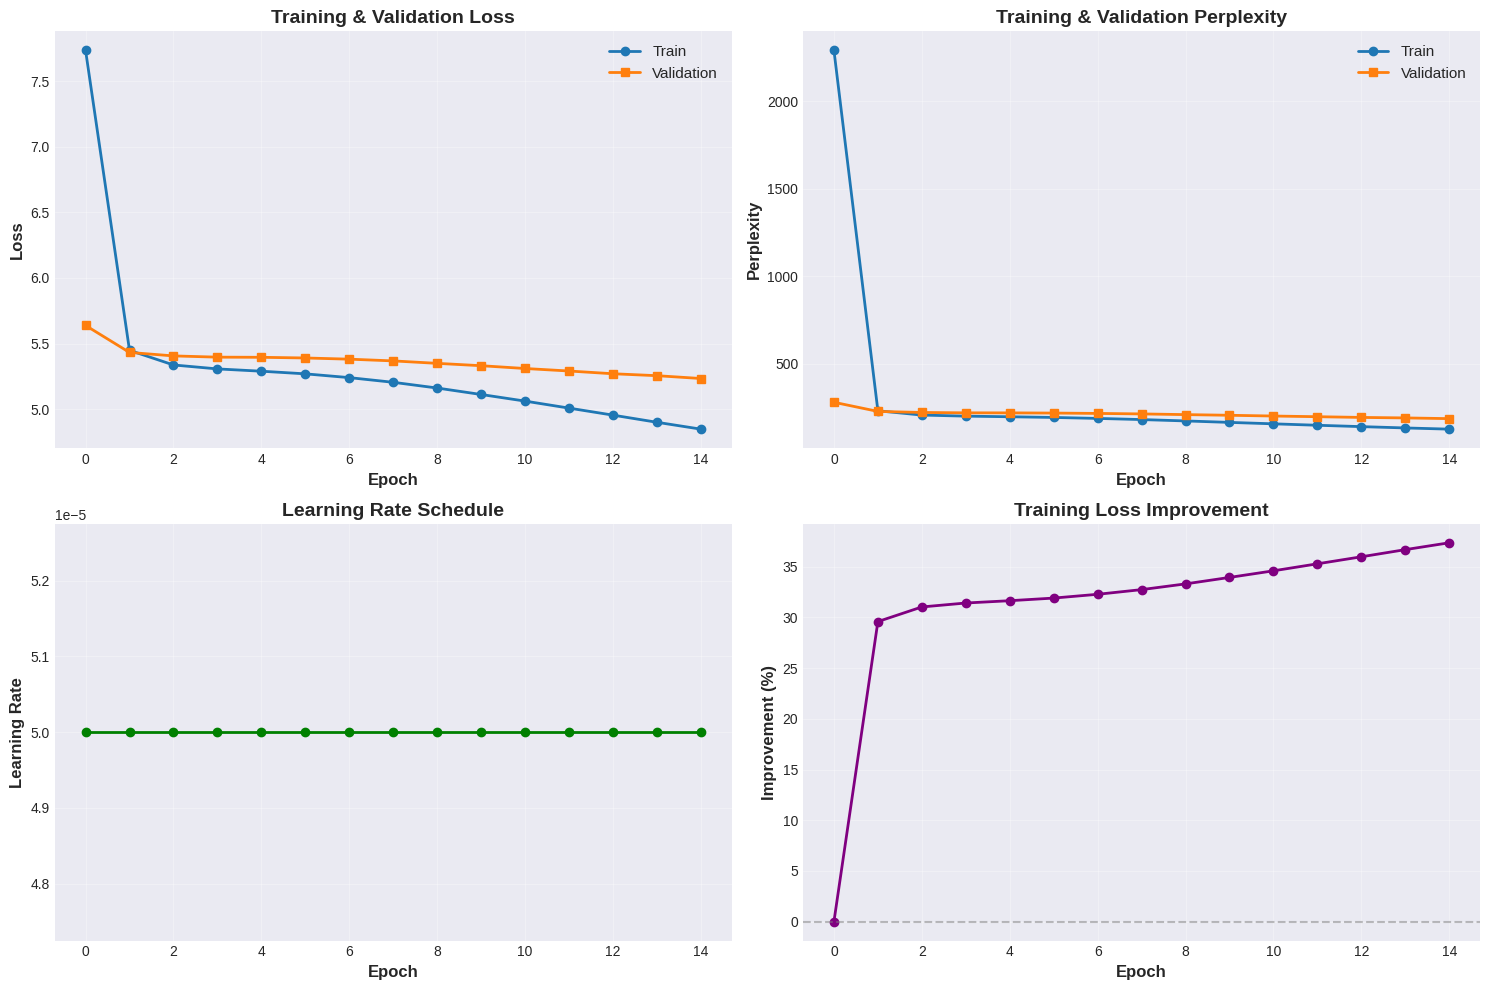

In [15]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
ax = axes[0, 0]
ax.plot(history['train_loss'], label='Train', marker='o', linewidth=2)
ax.plot(history['val_loss'], label='Validation', marker='s', linewidth=2)
ax.set_xlabel('Epoch', fontweight='bold', fontsize=12)
ax.set_ylabel('Loss', fontweight='bold', fontsize=12)
ax.set_title('Training & Validation Loss', fontweight='bold', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Perplexity
ax = axes[0, 1]
ax.plot(history['train_ppl'], label='Train', marker='o', linewidth=2)
ax.plot(history['val_ppl'], label='Validation', marker='s', linewidth=2)
ax.set_xlabel('Epoch', fontweight='bold', fontsize=12)
ax.set_ylabel('Perplexity', fontweight='bold', fontsize=12)
ax.set_title('Training & Validation Perplexity', fontweight='bold', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Learning Rate
ax = axes[1, 0]
ax.plot(history['lr'], marker='o', color='green', linewidth=2)
ax.set_xlabel('Epoch', fontweight='bold', fontsize=12)
ax.set_ylabel('Learning Rate', fontweight='bold', fontsize=12)
ax.set_title('Learning Rate Schedule', fontweight='bold', fontsize=14)
ax.grid(True, alpha=0.3)

# Loss Improvement
improvement = [(history['train_loss'][0] - l) / history['train_loss'][0] * 100 
               for l in history['train_loss']]
ax = axes[1, 1]
ax.plot(improvement, marker='o', color='purple', linewidth=2)
ax.set_xlabel('Epoch', fontweight='bold', fontsize=12)
ax.set_ylabel('Improvement (%)', fontweight='bold', fontsize=12)
ax.set_title('Training Loss Improvement', fontweight='bold', fontsize=14)
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(model_output_dir / 'training_history.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved training visualization to {model_output_dir / 'training_history.png'}")
plt.show()

In [16]:
# Save training history CSV
history_df = pd.DataFrame(history)
history_df.to_csv(model_output_dir / 'training_history.csv', index=False)
print(f"✓ Saved training history to {model_output_dir / 'training_history.csv'}")

# Display final metrics
print(f"\n{'='*70}")
print(f"FINAL TRAINING METRICS")
print(f"{'='*70}")
print(history_df.tail(10).to_string(index=False))

✓ Saved training history to /home/tpi/distil_shahreyar/artifacts/apache_attack_finetune_model/training_history.csv

FINAL TRAINING METRICS
 train_loss  train_ppl  val_loss    val_ppl      lr
   5.268554 194.134955  5.389597 219.115020 0.00005
   5.239702 188.613926  5.380539 217.139221 0.00005
   5.204035 182.005106  5.367253 214.273484 0.00005
   5.160310 174.218485  5.348596 210.312800 0.00005
   5.111006 165.837129  5.330573 206.556251 0.00005
   5.060554 157.677834  5.309299 202.208331 0.00005
   5.007117 149.473237  5.290144 198.371929 0.00005
   4.953535 141.674911  5.269221 194.264504 0.00005
   4.898999 134.155454  5.254491 191.424023 0.00005
   4.846620 127.309409  5.232925 187.339995 0.00005


## 10. Model Summary & Metadata

In [17]:
# Generate comprehensive model summary
summary = {
    'model_name': 'Apache Attack Detection Transformer',
    'base_model': 'OpenStack Pre-trained Transformer',
    'training_dataset': {
        'source': 'apache_training_150k.log',
        'total_logs': int(len(df)),
        'total_sequences': len(sequences),
        'train_sequences': train_size,
        'val_sequences': val_size,
        'normal_logs': label_data['normal_logs'],
        'attack_logs': label_data['attack_logs'],
        'attack_ratio': label_data['attack_ratio'],
        'attack_types': label_data['attack_types']
    },
    'vocabulary': {
        'size': apache_vocab_size,
        'total_with_special': apache_total_vocab,
        'pad_id': apache_pad_id,
        'path': str(vocab_output_dir / 'template_vocab.json')
    },
    'architecture': {
        'd_model': model_cfg['d_model'],
        'n_layers': model_cfg['n_layers'],
        'n_heads': model_cfg['n_heads'],
        'ffn_dim': model_cfg['ffn_dim'],
        'dropout': model_cfg['dropout'],
        'max_length': max_seq_len,
        'total_parameters': sum(p.numel() for p in model.parameters()),
        'trainable_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad)
    },
    'training': {
        'epochs': EPOCHS,
        'batch_size': batch_size,
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY,
        'warmup_steps': WARMUP_STEPS,
        'gradient_clipping': GRAD_CLIP,
        'optimizer': 'AdamW'
    },
    'performance': {
        'best_val_loss': float(best_val_loss),
        'best_val_ppl': float(math.exp(min(best_val_loss, 50))),
        'final_train_loss': float(history['train_loss'][-1]),
        'final_train_ppl': float(history['train_ppl'][-1]),
        'final_val_loss': float(history['val_loss'][-1]),
        'final_val_ppl': float(history['val_ppl'][-1]),
        'loss_improvement_pct': float(improvement[-1])
    },
    'model_path': str(model_output_dir / 'best.pt'),
    'created_at': datetime.now().isoformat()
}

# Save summary
with open(model_output_dir / 'model_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n{'='*70}")
print(f"APACHE ATTACK DETECTION MODEL SUMMARY")
print(f"{'='*70}")
print(json.dumps(summary, indent=2))

print(f"\n{'='*70}")
print(f"✓ Fine-tuning complete!")
print(f"{'='*70}")
print(f"\n📊 Model Statistics:")
print(f"  Total parameters:     {summary['architecture']['total_parameters']:,}")
print(f"  Vocabulary size:      {apache_vocab_size:,}")
print(f"  Training sequences:   {train_size:,}")
print(f"  Best val loss:        {best_val_loss:.4f}")
print(f"  Best val perplexity:  {summary['performance']['best_val_ppl']:.2f}")

print(f"\n🎯 Next Steps:")
print(f"  1. Use this model for attack detection on test Apache logs")
print(f"  2. Model has learned both normal and attack patterns")
print(f"  3. Apply anomaly detection with learned representations")
print(f"  4. Evaluate on ground truth labels from apache_training_150k_labels.json")


APACHE ATTACK DETECTION MODEL SUMMARY
{
  "model_name": "Apache Attack Detection Transformer",
  "base_model": "OpenStack Pre-trained Transformer",
  "training_dataset": {
    "source": "apache_training_150k.log",
    "total_logs": 150000,
    "total_sequences": 14414,
    "train_sequences": 12972,
    "val_sequences": 1442,
    "normal_logs": 127584,
    "attack_logs": 22416,
    "attack_ratio": 0.15,
    "attack_types": {
      "sqli": 3395,
      "xss": 2671,
      "path_traversal": 2252,
      "cmd_injection": 1737,
      "brute_force": 4408,
      "scanner": 3491,
      "ddos": 2267,
      "data_exfil": 1086,
      "api_abuse": 1109
    }
  },
  "vocabulary": {
    "size": 23705,
    "total_with_special": 23706,
    "pad_id": 23705,
    "path": "/home/tpi/distil_shahreyar/artifacts/apache_attack_finetune/template_vocab.json"
  },
  "architecture": {
    "d_model": 256,
    "n_layers": 6,
    "n_heads": 8,
    "ffn_dim": 1024,
    "dropout": 0.1,
    "max_length": 100,
    "total_